In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, Statistics, Plots, LaTeXStrings

# import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
# header = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ", "split"]

raw_params = CSV.read("../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv", DataFrame, header=1)

# Set this to zero to analyze all epochs, and a natural number n for the last n epochs

last_n_rows = 0; # plot the last n epochs, set to 0 to ignore
start_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore
end_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


In [5]:
rename!(raw_params, :Column9 => :split)
rename!(raw_params, :name => :species)
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows),
    split = fill("abc", num_rows)
) ;

processed_data.species = unique_values;


In [6]:
num_epochs_plotting = 0
vmin = 0
vmax = 0

for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs_plotting = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.common_name)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
    processed_data[row_number_processed,:split] = [raw_params_spec[1,:split]]

    if start_row_interval ≠ 0 && end_row_interval ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = start_row_interval:end_row_interval]]
        num_epochs_plotting = end_row_interval - start_row_interval + 1
        vmin = start_row_interval
        vmax = end_row_interval

    elseif last_n_rows ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        vmin = num_epochs_plotting - last_n_rows + 1
        vmax = num_epochs_plotting

        num_epochs_plotting = last_n_rows

    else
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs_plotting]]
        vmin = 1
        vmax = num_epochs_plotting
    end
    
end

processed_data = sort(processed_data, :Mw);
# println(num_epochs_plotting)

In [7]:
# contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
# processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), processed_data) 
# processed_data = sort(processed_data_lin_alkanes, :Mw);


species_to_filter = ["methane", "ethane","n-propane","n-butane","n-pentane","n-hexane","n-heptane","n-octane","n-nonane","n-decane","n-dodecane","n-pentadecane"]
vr_mie_source_params = filter(row -> lowercase(row.species) in species_to_filter, vr_mie_source_params);
pcp_source_params_alkanes = filter(row -> row.family == "Alkanes", pcp_source_params);

# raw_params_spec = filter(row -> contains(row.species, i), raw_params)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


[ Info: Saved animation to /home/mgadaloff/SAFT_ML/special_thingy_params/tmp.gif


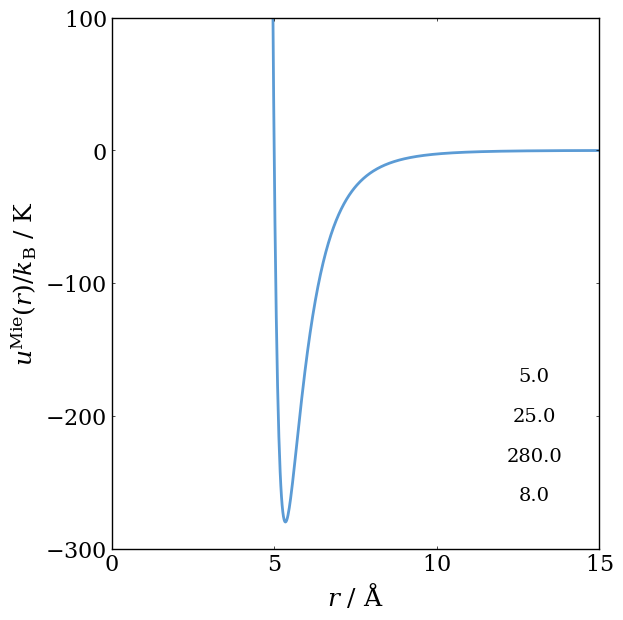

"output_animation.gif"

In [8]:
using Plots

pyplot()

# Set the font family and size
fontfamily = "serif"
fontsize = 14  # adjust the size as needed

default(legend = false)

frames_per_param = 150

zeroes = range(0,0,frames_per_param)

sigma_source = range(1, 5, length=frames_per_param)
epsilon_source = range(150,280, length=frames_per_param)
lambda_a_source = range(4, 8, length=frames_per_param)
lambda_r_source = range(10, 25, length=frames_per_param)

sigma_range = vcat(sigma_source,range(sigma_source[end],sigma_source[end],frames_per_param),range(sigma_source[end],sigma_source[end],frames_per_param),range(sigma_source[end],sigma_source[end],frames_per_param))
lambda_r_range = vcat(range(lambda_r_source[1],lambda_r_source[1],frames_per_param),lambda_r_source,range(lambda_r_source[end],lambda_r_source[end],frames_per_param),range(lambda_r_source[end],lambda_r_source[end],frames_per_param))
epsilon_range = vcat(range(epsilon_source[1],epsilon_source[1],frames_per_param),range(epsilon_source[1],epsilon_source[1],frames_per_param),epsilon_source,range(epsilon_source[end],epsilon_source[end],frames_per_param))
lambda_a_range = vcat(range(lambda_a_source[1],lambda_a_source[1],frames_per_param),range(lambda_a_source[1],lambda_a_source[1],frames_per_param),range(lambda_a_source[1],lambda_a_source[1],frames_per_param),lambda_a_source)

x = range(0, 20, 1000)

n = frames_per_param*4

@gif for i = 1:n

    u = ( (lambda_r_range[i]/(lambda_r_range[i] - lambda_a_range[i])) * (lambda_r_range[i]/lambda_a_range[i]) ^ (lambda_a_range[i]/(lambda_r_range[i] - lambda_a_range[i])) ) .* epsilon_range[i] .* ( (sigma_range[i] ./ x) .^ lambda_r_range[i] .- (sigma_range[i] ./ x) .^ lambda_a_range[i])

    plot(x, u, dpi=400, size=(600, 600), color="#5B9BD5",linewidth=2, guidefontsize=18, xtickfontsize=16, ytickfontsize=16,grid=false,fontfamily = "serif",framestyle = :box),

    # xlabel!("\$σ\$ / Å",fontfamily = "serif")

    xlabel!("\$r\$ / Å")
    ylabel!("\$u\\mathrm{^{Mie}}(r)/k\\mathrm{_B} \$ / K")

    xlims!(0, 15)
    ylims!(-300, 100)

    # str = "sigma: $(round(sigma_range[i], digits=2)), \nlambda_r: $(round(lambda_r_range[i], digits=2)), \nepsilon: $(round(epsilon_range[i], digits=2)), \nlambda_a: $(round(lambda_a_range[i], digits=2))"
    # annotate!(15, -250, str, halign=:left, valign = :top)

    sigma_str = "$(round(sigma_range[i], digits=2))"
    lambda_r_str = "$(round(lambda_r_range[i], digits=2))"
    epsilon_str = "$(round(epsilon_range[i], digits=2))"
    lambda_a_str = "$(round(lambda_a_range[i], digits=2))"
    
    annotate!(13, -170, sigma_str, valign=:top,fontsize=16)
    annotate!(13, -200, lambda_r_str, valign=:top,fontsize=16)
    annotate!(13, -230, epsilon_str, valign=:top,fontsize=16)
    annotate!(13, -260, lambda_a_str, valign=:top,fontsize=16)

    println(i)

end fps=25; output_file = "output_animation.gif"



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


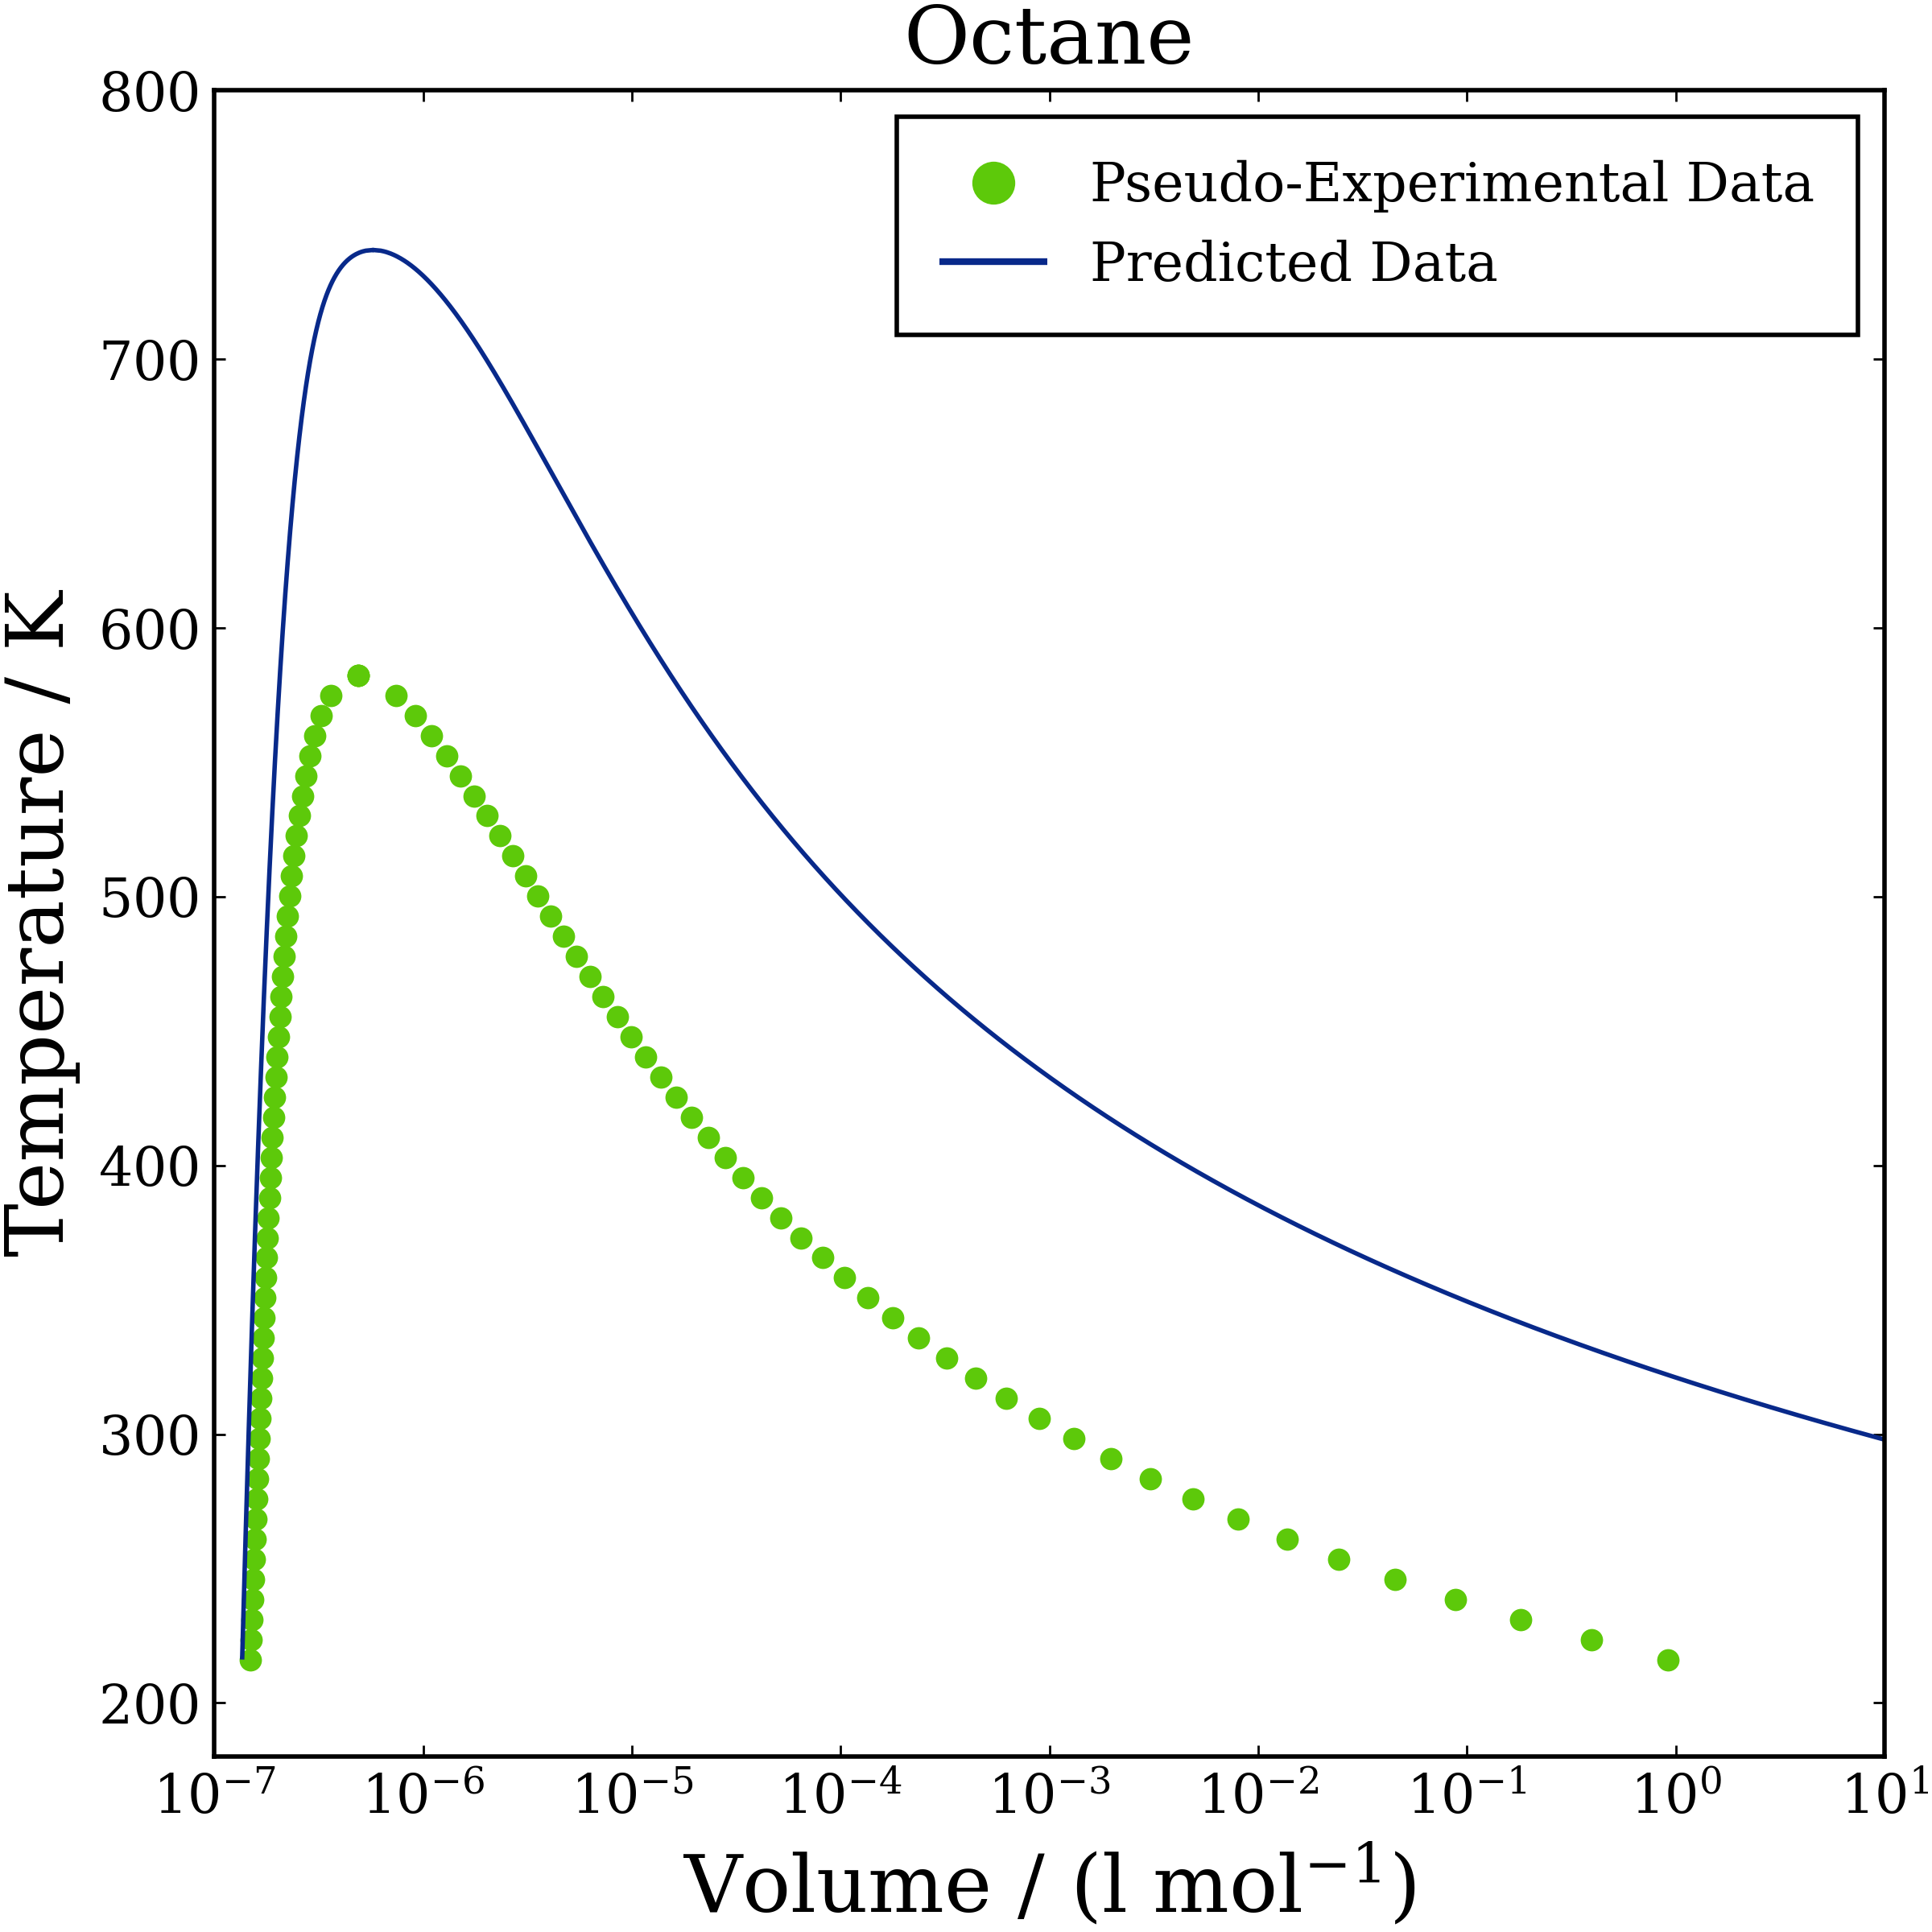

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [32]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)
test_species = "Octane"
plot_all_exptl_data = true
npoints_exptl = 50
npoints_vrmie = 2000

source_data_test_species = filter(row -> row.common_name == lowercase(test_species), pcp_source_params)
processed_data_test_species = filter(row -> row.species == lowercase(test_species), processed_data)

v_liq_range_pcp = [];
v_vap_range_pcp = [];
p_range_pcp = [];

# Create PCP-Saft Model
pcp_model = PPCSAFT([test_species])
Tc_pcp, pc_pcp, Vc_pcp = crit_pure(pcp_model)

# set experimental data range
if plot_all_exptl_data == false
    Tmin = source_data_test_species.expt_T_min_liberal[1]
    Tmax = min(500, 0.95*Tc_pcp,source_data_test_species.expt_T_max_conservative[1])
else
    Tmin = min(source_data_test_species.expt_T_min_liberal[1],0.5 * Tc_pcp)
    Tmax = Tc_pcp
end

T_range_pcp = collect(range(Tmin, Tmax, npoints_exptl))

# compute pseudo-experimental data
for T in T_range_pcp
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
    push!(v_liq_range_pcp, v_liq_sat)
    push!(v_vap_range_pcp, v_vap_sat)
    push!(p_range_pcp,p_sat)
end

v_range_pcp_plot = vcat(v_liq_range_pcp, Vc_pcp, v_vap_range_pcp)
p_range_pcp_plot = vcat(p_range_pcp, pc_pcp, p_range_pcp)

# Create arrays to store sat. envelopes
sat_T_envelopes = []
sat_rho_envelopes = []
sat_v_envelopes = []

number_epochs = length(processed_data_test_species[1,:m])

for i = 1:number_epochs

    v_liq_range_vrmie = [];  v_vap_range_vrmie = []; p_range_vrmie = [];

    println(i)

    Mw_test_species = processed_data_test_species[1,:Mw]
    m_test_species = processed_data_test_species[1,:m][i]
    σ_test_species = processed_data_test_species[1,:σ][i]
    λ_a_test_species = processed_data_test_species[1,:λ_a][i]
    λ_r_test_species = processed_data_test_species[1,:λ_r][i]
    ϵ_test_species = processed_data_test_species[1,:ϵ][i]

    vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

    Tc0 = BigFloat.(Clapeyron.x0_crit_pure(vrmie_model))
    options = Clapeyron.NEqOptions(maxiter=20_000)
    Tc_vrmie, pc_vrmie, Vc_vrmie = Float64.(crit_pure(vrmie_model, Tc0; options=options))

    T_range_vrmie = collect(range(Tmin, Tc_vrmie, npoints_vrmie))

    for T in T_range_vrmie
        if isempty(v_liq_range_vrmie)
            method = ChemPotVSaturation()
        else
            method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
        end
        (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
        push!(v_liq_range_vrmie, v_liq_sat)
        push!(v_vap_range_vrmie, v_vap_sat)
        push!(p_range_vrmie, p_sat)
    end

    v_range_vrmie_plot = vcat(v_liq_range_vrmie, Vc_vrmie, reverse(v_vap_range_vrmie))
    p_range_vrmie_plot = vcat(p_range_vrmie, pc_vrmie, reverse(p_range_vrmie))

    vrmie_nan_indices = findall(isnan, v_range_vrmie_plot)
    v_range_vrmie_plot = v_range_vrmie_plot[setdiff(1:length(v_range_vrmie_plot), vrmie_nan_indices)]
    p_range_vrmie_plot = p_range_vrmie_plot[setdiff(1:length(p_range_vrmie_plot), vrmie_nan_indices)]

    push!(sat_T_envelopes, vcat(T_range_vrmie,Tc_vrmie,reverse(T_range_vrmie)))
    push!(sat_rho_envelopes, 1e-3 ./ v_range_vrmie_plot)
    push!(sat_v_envelopes, v_range_vrmie_plot)

end

T_range_pcp_plot = vcat(T_range_pcp, Tc_pcp, T_range_pcp)
rho_range_pcp_plot = 1e-3 ./ v_range_pcp_plot;

plot(v_range_pcp_plot ./ 10^3 , T_range_pcp_plot, seriestype=:scatter,dpi=400, size=(600, 600),framestyle=:box, fontfamily="serif",markercolor="#5dc90a",markerstrokealpha=0,markersize=5,label="Pseudo-Experimental Data", guidefontsize=18,titlefontsize=18, xtickfontsize=12, ytickfontsize=12,legendfontsize=12)
plot!(sat_v_envelopes[1] ./ 10^3, sat_T_envelopes[1],xscale=:log10,linecolor="#08298a",label="Predicted Data",legend=:topright,grid=false)

ylabel!("Temperature / K")
xlabel!(L"Volume / (l mol$\mathregular{^{-1}}$)")
# xscale(:log10)
xlims!(10^-7,10^1)
ylims!(180,800)
xticks!([10^-7, 10^-6, 10^-5, 10^-4,10^-3,10^-2, 10^-1, 10^-0, 10^1])
title!(test_species)

# savefig("Example_phase_envelope.svg")

In [34]:
num_rows = length(sat_v_envelopes)

overview_gif_data = DataFrame(
    sat_v_envel = fill([0.0], num_rows),
    sat_T_envel = fill([0.0], num_rows),
) ;

overview_gif_data.sat_v_envel = sat_v_envelopes
overview_gif_data.sat_T_envel = sat_T_envelopes
overview_gif_data;

In [35]:
# CSV.write("overview_gif_data_octane_volume.csv", overview_gif_data) ;

In [8]:
# overview_gif_data_raw = CSV.read("../special_thingy_params/overview_gif_data.csv", DataFrame, header=1);

In [9]:
# num_rows = nrow(overview_gif_data_raw)

# overview_gif_data = DataFrame(
#     sat_rho_envel = fill([0.0], num_rows),
#     sat_T_envel = fill([0.0], num_rows),
# ) ;

# for j = 1:ncol(overview_gif_data_raw)
#     for i = 1:num_rows

#         values_str = split(strip(overview_gif_data_raw[i,j], ['[', ']']), ", ")
#         values = parse.(Float64, values_str)
#         vector_of_floats = collect(values)

#         overview_gif_data[i,j] = vector_of_floats
#     end
# end

1
2


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


3


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


4


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


5


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


6


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


7


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


8


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


9


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


10


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


11


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


12


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


13


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


14


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


15


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


16


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


17


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


18


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


19


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


20


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


21


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


22


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


23


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


24


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


25


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


26


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


27


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


28


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


29


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


30


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


31


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


32


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


33


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


34


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


35


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


36


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


37


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


38


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


39


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


40


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


41


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


42


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


43


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


44


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


45


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


46


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


47


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


48


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


49


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


50


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


51


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


52


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


53


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


54


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


55


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


56


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


57


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


58


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


59


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


60


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


61


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


62


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


63


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


64


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


65


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


66


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


67


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


68


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


69


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


70


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


71


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


72


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


73


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


74


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


75


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


76


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


77


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


78


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


79


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


80


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


81


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


82


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


83


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


84


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


85


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


86


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


87


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


88


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


89


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


90


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


91


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


92


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


93


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


94


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


95


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


96


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


97


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


98


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


99


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


100


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


101


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


102


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


103


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


104


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


105


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


106


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


107


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


108


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


109


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


110


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


111


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


112


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


113


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


114


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


115


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


116


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


117


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


118


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


119


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


120


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


121


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


122


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


123


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


124


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


125


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


126


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


127


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


128


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


129


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


130


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


131


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


132


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


133


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


134


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


135


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


136


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


137


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


138


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


139


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


140


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


141


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


142


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


143


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


144


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


145


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


146


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


147


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


148


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


149


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


150


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


151


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


152


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


153


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


154


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


155


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


156


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


157


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


158


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


159


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


160


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


161


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


162


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


163


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


164


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


165


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


166


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


167


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


168


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


169


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


170


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


171


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


172


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


173


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


174


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


175


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


176


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


177


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


178


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


179


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


180


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


181


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


182


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


183


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


184


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


185


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


186


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


187


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


188


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


189


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


190


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


191


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


192


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


193


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


194


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


195


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


196


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


197


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


198


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


199


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


200


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


201


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


202


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


203


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


204


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


205


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


206


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


207


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


208


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


209


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


210


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


211


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


212


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


213


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


214


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


215


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


216


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


217


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


218


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


219


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


220


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


221


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


222


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


223


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


224


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


225


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


226


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


227


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


228


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


229


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


230


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


231


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


232


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


233


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


234


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


235


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


236


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


237


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


238


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


239


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


240


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


241


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


242


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


243


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


244


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


245


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


246


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


247


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


248


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


249


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


250


sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
[ Info: Saved animation to /home/mgadaloff/SAFT_ML/special_thingy_params/tmp.gif


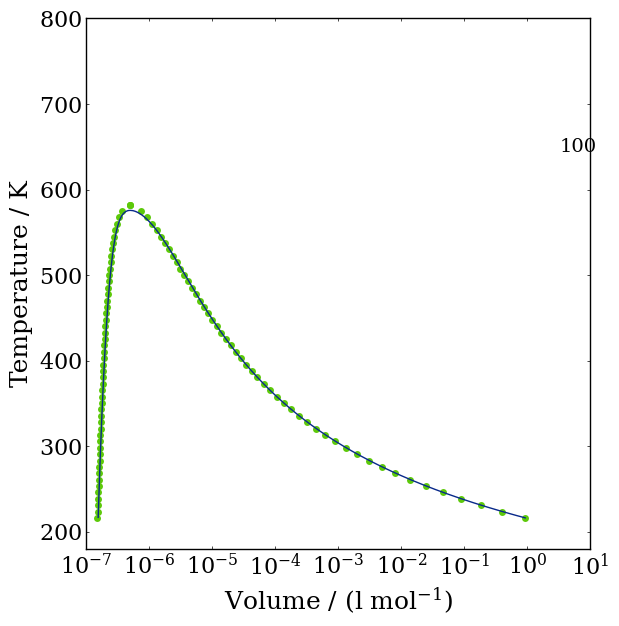

In [39]:
# Set pyplot backend for plots
using Plots
pyplot()

tick_font_size = 16
label_font_size = 18
total_frames =  250 #nrow(overview_gif_data)

marker_colour = "#5dc90a"
marker_size = 8

default(legend = false)

@gif for i = 1:1:total_frames
    
    plot(v_range_pcp_plot ./ 10^3, T_range_pcp_plot, seriestype=:scatter,dpi=400, size=(600, 600),framestyle=:box, fontfamily="serif",markercolor="#5dc90a",markerstrokealpha=0,markersize=5, guidefontsize=label_font_size,titlefontsize=label_font_size, xtickfontsize=tick_font_size, ytickfontsize=tick_font_size,legendfontsize=12);

    if i <= 150
        plot!(overview_gif_data[i,1] ./ 10^3, xscale=:log10, overview_gif_data[i,2],linecolor="#08298a",grid=false);
        percent_training = "$(round((i/200)*100, sigdigits=3))"
    elseif i <= 200
        plot!(overview_gif_data[i*5,1] ./ 10^3, overview_gif_data[i*5,2], xscale=:log10, linecolor="#08298a",grid=false);
        percent_training = "$(round((i/200)*100, sigdigits=3))"
    else
        plot!(overview_gif_data[1000,1] ./ 10^3, overview_gif_data[1000,2], xscale=:log10, linecolor="#08298a",grid=false);
        percent_training = "$(100)"
    end

    ylabel!("Temperature / K")
    xlabel!(L"Volume / (l mol$\mathregular{^{-1}}$)")
    xlims!(10^-7,10^1)
    ylims!(180,800)
    # title!(test_species)
    xticks!([10^-7, 10^-6, 10^-5, 10^-4,10^-3,10^-2, 10^-1, 10^-0, 10^1])

        
    annotate!(6.5, 650, percent_training, valign=:top,fontsize=16)

    println(i)
    # xlims!(10^-8,10^5)  # Adjust the values as needed
    # ylims!(10^-3, 10^7)

end fps=25;

